# Application example
This is simple example of how to use the estimated connectivity models to make predictions about the cerebellar activity pattern for new data. 

The example uses the `Functional_Fusion` repository to read out gifti/nifti files at the predefined voxel locations (atlas). 

Finally, it uses the the `SUITPy` to visualize the observed and predicted activity patterns.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.model as model
import Functional_Fusion.atlas_map as am 
import Functional_Fusion.dataset as ds
import nibabel as nb
import matplotlib.pyplot as plt
import SUITPy as suit

##  Read the cortical data 
The data needs to be read into the correct atlas space and parcellation
As an example, we are using MDTB group-averaged data from the first session. 

The correct sampling of the data is taken care of by the `Functional_Fusion` repository.

In [2]:
# Define and atlas and read the data 
cortex_atlas,_  = am.get_atlas('fs32k')
cifti_img = nb.load('../data/group_space-fs32k_ses-s1_CondAll.dscalar.nii')
D=cortex_atlas.read_data(cifti_img)
print(f'The data is {D.shape[0]} conditions by {D.shape[1]} surface vertices')

The data is 29 conditions by 59518 surface vertices


In [3]:
# The data needs to now be averaged within the cortical regions
adir = am.default_atlas_dir
cortex_roi = [f"{adir}/tpl-fs32k/Icosahedron1002.L.label.gii",
               f"{adir}/tpl-fs32k/Icosahedron1002.R.label.gii"]
# Read the ROI files
label_vec,labels = cortex_atlas.get_parcel(cortex_roi)

# Aggregate the data within the regions
Dn,_ = ds.agg_parcels(D,label_vec,fcn=np.nanmean)
print(f'The aggregated data is {Dn.shape[0]} conditions by {Dn.shape[1]} ROIs vertices')

The aggregated data is 29 conditions by 1876 ROIs vertices


##  Get the connectivity model
The weights of the connectivity model are saved in a `pdconn.nii` file. These are connectivity weights (conn) for each cortical parcel (p) for each cerebellar voxels in dense representation (d).   

Text(0, 0.5, 'Cortical ROI')

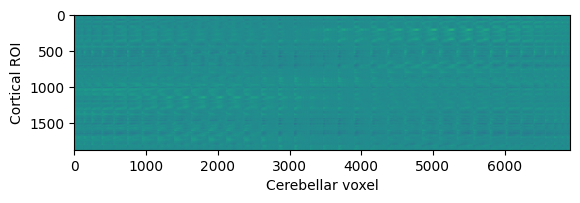

In [4]:
M = model.Model('my_model')
M.from_cifti('../data/Nettekoven_2024_Fusion_L2.pdconn.nii')
# Plot the connectivity matrix 
plt.imshow(M.coef_.T)
plt.xlabel('Cerebellar voxel')
plt.ylabel('Cortical ROI')

## Make the prediction from the model
To make prediction from the model, we just submit the cortical data to the model. The `predict` function returns the predicted cerebellar activity pattern. 

In [5]:
Y_hat = M.predict(Dn)

## Load the real data for comparison
To read the real data, we are again using the `Functional_Fusion` repository to read out the data at the predefined voxel locations (atlas).
You can also use the `read_data` function on any nifti file in SUIT space.  

In [7]:
cereb_atlas,_ = am.get_atlas('SUIT3')
cifti_img = nb.load('../data/group_space-SUIT3_ses-s1_CondAll.dscalar.nii')
Y = cereb_atlas.read_data(cifti_img).T

## Plot real and predicted data
To investigate the prediction, you can transform the data back into a nifti-image and map in onto the cerebellar flatmap. 
Note that due to the regularization of the model, the predicted data will have a lower amplitude (closer to zero) than the real data. 
We are adjusting the color scaling in the plot accordingly.

Text(0.5, 1.0, 'ToM observed')

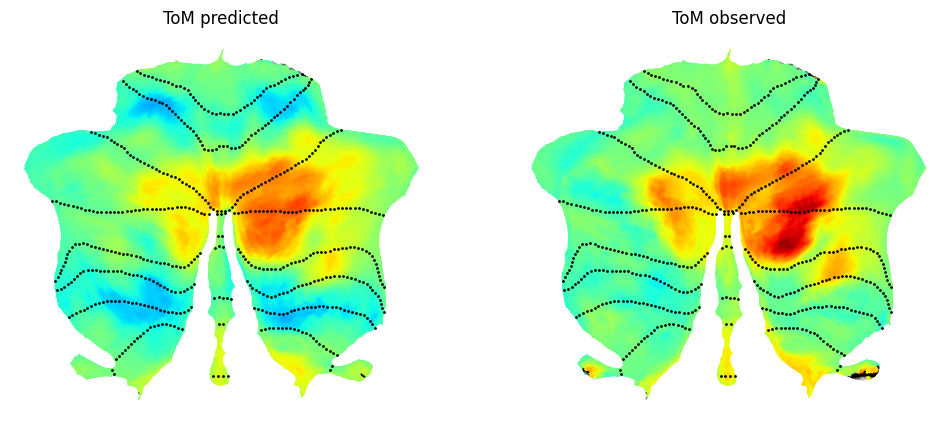

In [8]:
def plot_cereb_data(data,cereb_atlas,cscale=[-0.1,0.1]):
    # Transform the data to a nifti image
    nifti_img = cereb_atlas.data_to_nifti(data)
    # Map to the cerebellar flatmap 
    flat_data = suit.flatmap.vol_to_surf(nifti_img)
    # Plot 
    suit.flatmap.plot(flat_data,new_figure=False,cscale=cscale)

# Get condition names and select a condition number 
labels = cifti_img.header.get_axis(0).name
cond_num = 2

# Plot the predicted and observed data for the selected condition
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plot_cereb_data(Y_hat[cond_num,:],cereb_atlas,cscale=[-0.1,0.1])
plt.title(f'{labels[cond_num]} predicted')
plt.subplot(1,2,2)
plot_cereb_data(Y[cond_num,:],cereb_atlas,cscale=[-0.2,0.2])
plt.title(f'{labels[cond_num]} observed')